# Homework 4: Fun with Point Clouds

## Problem 1: Point Cloud Fusion

### Part 1: Harris Corner Detection

#### Code Imports

In [1]:
# optional: allow Jupyter to "hot reload" the modules we import - after each change, rerun this cell (instead of restarting the kernel!!)
%load_ext autoreload
%autoreload 2

In [2]:
import glob

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from util import ops
from util.corner_detection import HarrisCornerDetector

### Load Data

In [3]:
rgb_paths = sorted(glob.glob("../hw4_data/problem1/rgb*"))
rgb_paths

['../hw4_data/problem1/rgb1.png',
 '../hw4_data/problem1/rgb2.png',
 '../hw4_data/problem1/rgb3.png']

In [4]:
illumination_images = [
    ops.load_image(
        path,
        return_grayscale=True,
        return_array=True
    )
    for path in rgb_paths
]

Dimensions of ../hw4_data/problem1/rgb1.png: 480 x 640
Dimensions of ../hw4_data/problem1/rgb2.png: 480 x 640
Dimensions of ../hw4_data/problem1/rgb3.png: 480 x 640


For convenience, let's map the filename of each RGB image, to the image itself.

And let's also load in the depth map images in a similar fashion:

In [5]:
depthmap_paths = sorted(glob.glob("../hw4_data/problem1/depth*"))
depthmap_paths

['../hw4_data/problem1/depth1.png',
 '../hw4_data/problem1/depth2.png',
 '../hw4_data/problem1/depth3.png']

In [6]:
depthmaps = [
    ops.load_image(
        path,
        return_grayscale=True,
        return_array=True
    )
    for path in depthmap_paths
]

Dimensions of ../hw4_data/problem1/depth1.png: 480 x 640
Dimensions of ../hw4_data/problem1/depth2.png: 480 x 640
Dimensions of ../hw4_data/problem1/depth3.png: 480 x 640


#### Determine Feature that Will Be Used to Fuse Point Clouds 

We begin by setting the hyperparameters given in in the hw 4 description:

In [7]:
derivative_operator_x = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
])
derivative_operator_y = derivative_operator_x.T

In [8]:
# using the Gaussian filter provided here: https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm
gaussian_window = np.array([
    [1, 4, 7, 4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1, 4, 7, 4, 1],
])

gaussian_window = gaussian_window * (1 / 273)

In [9]:
NUM_FEATURES_TO_SELECT = 100

Then let's go ahead and apply the Harris Corner detector:

In [10]:
path_to_image_and_corners = dict()

detector = HarrisCornerDetector()

for rgb_path, image in zip(rgb_paths, illumination_images):

    corner_response = detector.detect_features(
        image,
        use_non_max_suppression=True,
        derivative_operator_x=derivative_operator_x,
        derivative_operator_y=derivative_operator_y,
        gaussian_window=gaussian_window,
    )
    # pick top features
    top_k_points = detector.pick_top_features(
        corner_response,
        NUM_FEATURES_TO_SELECT
    )

    path_to_image_and_corners[rgb_path] = (image, top_k_points)

In [11]:
path_to_image_and_corners[rgb_paths[0]][1].shape

(100, 3)

### Part 2: Corners to 3D Points

We begin by setting the hyperparameters given in in the hw 4 description:

In [12]:
S = 5000

In [13]:
calibration_matrix = K = np.array([
    [525.,    0, 319.5],
    [0,    525., 239.5],
    [0,       0,     1]
])

Then we can project out the 3D points corresponding to the detected corners:

In [14]:
from numpy import linalg

def convert_1_corner_to_3d(
        xy_and_depth: tuple[int, int, float],
        K: np.ndarray,
        S: int,
    ) -> np.ndarray:
    """
    Follows the equation given in the hw 4 description.

    Assumes the depth is not 0.

    Parameters:
        xy_and_depth(tuple): pixel coordinates and depth
            of a detected corner
        K(np.ndarray): 3x3 camera intrinsic matrix
        S(int)

    Returns: np.array - a row vector representing 3D worldspace
        coordinates of the corner
    """
    x, y, depth_val = xy_and_depth

    image_coordinates_homogenous = np.array([x, y, 1]).T
    worldspace_coordinates = (
        (1 / S)  * depth_val * (linalg.inv(K) @ image_coordinates_homogenous)
    )

    assert worldspace_coordinates.shape == (3,)

    return worldspace_coordinates


Let's apply this function across all the corners, in all the images:

In [15]:
path_to_3d_points = dict()

for image_index, image_path in enumerate(rgb_paths):

     # per image, convert appropiate corners to 3d points
     _, top_k_points = path_to_image_and_corners[image_path]
     top_k_points = top_k_points.astype(int)
     corresponding_depthmap = depthmaps[image_index]
     depth_vals = corresponding_depthmap[
          top_k_points[:, 0],
          top_k_points[:, 1]
     ].reshape(-1, 1)

     image_and_world_space_coordinates_per_image = dict()

     for depth_val_index, depth_val in enumerate(depth_vals):
          if depth_val != 0:
               x, y = (
                    top_k_points[depth_val_index, 1],
                    top_k_points[depth_val_index, 0],
               )
               X, Y, Z = convert_1_corner_to_3d(
                    (x, y, depth_val),
                    K,
                    S,
               )
               # store the pixel coordinates alongside the world space coordinates - might come in handy later
               image_and_world_space_coordinates_per_image[(x, y)] = (X, Y, Z)

     path_to_3d_points[image_path] = image_and_world_space_coordinates_per_image


Let's do a sanity check:

In [16]:
len(path_to_3d_points[rgb_paths[0]].items())

82

Ok, so about 18 of the corners had a depth of 0.

In [17]:
list(path_to_3d_points[rgb_paths[0]].items())[:3]

[((540, 347),
  (0.021419999999999998, 0.010442857142857143, 0.051000000000000004)),
 ((89, 201),
  (-0.022391428571428573, -0.0037400000000000016, 0.051000000000000004)),
 ((541, 349),
  (0.021517142857142863, 0.010637142857142859, 0.051000000000000004))]

I guess the 3D coordinates look ok?

### Part 3: Corner Matching

#### Apply a Rank Transform to All of the Images

Using 5x5 windows here:

In [18]:
from util.rank_transform import RankTransform2D

In [19]:
illumination_images_rank_transformed = [
    RankTransform2D.transform(image, filter_side_length=5)
    for image in illumination_images
]

In [20]:
illumination_images_rank_transformed[0].shape == illumination_images[0].shape

True

Just as a visual sanity check - let's look at  one of the rank transformed images:

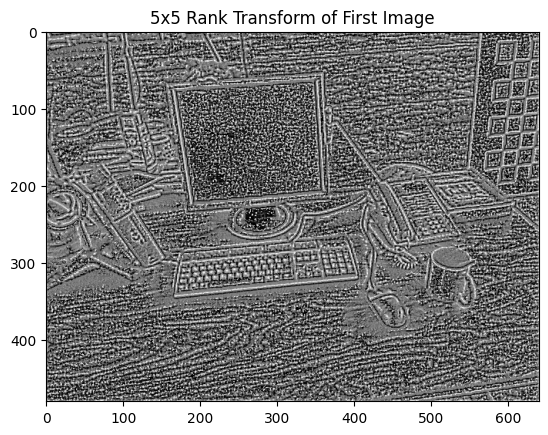

In [21]:
plt.imshow(illumination_images_rank_transformed[0], cmap="gray")
plt.title("5x5 Rank Transform of First Image")
plt.show()

#### Data Wrangling

I have a helper function to compute the putative correspondences. But it first requires us to associate the locations of the corners with their values in the corresponding rank transformed image (which I'm also referring to as its "descriptor" below) in an 11x11 window:

In [22]:
descriptors_of_all_images = dict()

for image_index, image_path in enumerate(rgb_paths):

    # per image, associate each corner location to its val in the rank transformed image
    corner_locations_to_3d_points = path_to_3d_points[image_path]
    corresponding_descriptor_image = illumination_images_rank_transformed[image_index]

    descriptors_per_image = list()

    for x, y in corner_locations_to_3d_points.keys():
        window = corresponding_descriptor_image[
            y-5 : y+6,
            x-5 : x+6
        ]
        descriptors_per_image.append([y, x, window])

    descriptors_of_all_images[image_path] = descriptors_per_image


#### Correspondence Search

In [23]:
from util.ops import SimilarityMeasure

In [24]:
NUM_DESIRED_MATCHES = 10  # determined by the hw 4 description

##### Images 2 and 1

In [25]:
image2_corner_descriptors = descriptors_of_all_images[rgb_paths[1]]  # remember, this is in the form [y, x, rank_transform_val]

In [26]:
image1_corner_descriptors = descriptors_of_all_images[rgb_paths[0]]

In [27]:
image1_corner_descriptors  # y, x, window

[[347,
  540,
  array([[12, 12, 11, 19, 17, 13, 10, 11, 13, 17,  7],
         [14, 12, 11, 14, 19, 12, 14, 11,  7, 10,  5],
         [13, 12, 12, 13, 15,  8, 10,  1,  9,  1,  4],
         [13, 11, 12, 14, 18, 15, 10, 11,  4,  4, 24],
         [11, 10, 12, 19, 19, 21, 15, 11,  3,  5, 17],
         [12,  5, 13, 14, 23, 22, 16, 12,  0,  3,  6],
         [13,  7, 13, 12, 13, 23, 17, 11, 11,  1, 11],
         [ 7,  5,  3, 11, 12, 15, 20, 19, 15, 13, 12],
         [ 5,  1,  1,  0, 12, 13, 18, 23, 20, 16, 13],
         [ 8,  6,  8,  3,  6, 14, 15, 17, 19, 17, 17],
         [12, 12, 14,  3,  6,  5, 13, 13, 15, 18, 17]])],
 [201,
  89,
  array([[16, 10,  3,  1,  1, 15, 19, 16, 10,  1,  3],
         [ 4,  1,  8, 10, 10, 13, 17, 16, 13,  1,  3],
         [ 0,  5, 11, 11, 10, 12, 20, 16, 13, 12,  0],
         [13, 12, 12, 12, 16, 23, 20, 23, 11, 11, 13],
         [12, 12, 12, 14, 16, 18, 22, 19, 12, 11, 12],
         [12, 23, 17,  9, 10, 13, 14, 12, 19, 17, 12],
         [21, 16,  8, 11, 13, 14, 1

In [28]:
image_2_to_1_top_corner_matches = HarrisCornerDetector.compute_feature_correspondences(
    (image2_corner_descriptors, image1_corner_descriptors),
    desired_num_similarities=NUM_DESIRED_MATCHES,
    similarity_metric=SimilarityMeasure.SAD,
)

In [29]:
image_2_to_1_top_corner_matches  # this is in the form [y1, x1, y2, x2, sad_val]

array([[236., 245., 245., 468., 104.],
       [255., 268., 210.,  82., 112.],
       [230., 249., 215.,  85., 112.],
       [259., 270., 230.,  96., 113.],
       [222., 252., 322., 552., 113.],
       [217., 243., 221., 456., 114.],
       [229., 258., 245., 468., 114.],
       [236., 261., 227.,  93., 114.],
       [241., 263., 209.,  80., 114.],
       [216., 241., 263., 130., 115.]])

##### Images 2 and 3

In [30]:
image3_corner_descriptors = descriptors_of_all_images[rgb_paths[2]]

In [31]:
image_2_to_3_top_corner_matches = HarrisCornerDetector.compute_feature_correspondences(
    (image2_corner_descriptors, image3_corner_descriptors),
    desired_num_similarities=NUM_DESIRED_MATCHES,
    similarity_metric=SimilarityMeasure.SAD,
)

In [32]:
image_2_to_3_top_corner_matches

array([[219., 239., 195., 362., 121.],
       [218., 241., 188., 361., 122.],
       [220., 237., 224., 381., 122.],
       [212., 241., 432., 438., 123.],
       [219., 243., 175., 358., 123.],
       [215., 243., 413., 153., 124.],
       [212., 235., 169., 365., 126.],
       [221., 235., 186., 361., 126.],
       [210., 241., 434., 196., 127.],
       [218., 237., 177., 358., 127.]])

### Part 4: Pose Esimation

In [33]:
np.random.seed(42)

#### Estimating a Rigid Transformation

The goal here is to find the rotation `R` matrix and translation `t` that would explain away the camera motion between the images of the scene, in pairs of two.

##### Between Images 2 and 1

In [34]:
path_to_3d_points[rgb_paths[0]]  # for image 1, this tells us 2D --> 3D points for the pixels identified by Harris corner detection

{(540, 347): (0.021419999999999998,
  0.010442857142857143,
  0.051000000000000004),
 (89, 201): (-0.022391428571428573,
  -0.0037400000000000016,
  0.051000000000000004),
 (541, 349): (0.021517142857142863,
  0.010637142857142859,
  0.051000000000000004),
 (87, 203): (-0.022585714285714285,
  -0.003545714285714287,
  0.051000000000000004),
 (85, 204): (-0.02278, -0.0034485714285714297, 0.051000000000000004),
 (86, 206): (-0.02268285714285714,
  -0.0032542857142857148,
  0.051000000000000004),
 (84, 207): (-0.022877142857142856,
  -0.0031571428571428575,
  0.051000000000000004),
 (455, 219): (0.013162857142857146,
  -0.001991428571428572,
  0.051000000000000004),
 (86, 208): (-0.02268285714285714,
  -0.0030600000000000002,
  0.051000000000000004),
 (112, 237): (-0.020157142857142856,
  -0.00024285714285714484,
  0.051000000000000004),
 (89, 203): (-0.022391428571428573,
  -0.003545714285714287,
  0.051000000000000004),
 (95, 226): (-0.021808571428571427,
  -0.0013114285714285732,
  0.0

Let's start by directly associating correspondences between the images, in their 3d point representations:

In [64]:
image_2_to_1_3d_point_correspondences = list()
image2_pixel_to_world_coords = path_to_3d_points[rgb_paths[1]]
image1_pixel_to_world_coords = path_to_3d_points[rgb_paths[0]]

for image_2_to_1_top_corner_match in image_2_to_1_top_corner_matches:
    img2_y, img2_x, img1_y, img1_x, _ = image_2_to_1_top_corner_match
    img2_y, img2_x, img1_y, img1_x = np.array([img2_y, img2_x, img1_y, img1_x]).astype(int)  # hacking the dtype to stay consistent
    image2_3d_point = image2_pixel_to_world_coords[(img2_x, img2_y)]
    image1_3d_point = image1_pixel_to_world_coords[(img1_x, img1_y)]  # this point is real, just need to figure out why it's not in the list of initial harris corners?

    image_2_to_1_3d_point_correspondences.append(np.concatenate([image2_3d_point, image1_3d_point]).squeeze())

image_2_to_1_3d_point_correspondences = np.asarray(image_2_to_1_3d_point_correspondences)


In [65]:
image_2_to_1_3d_point_correspondences.shape  # (make this 10, 6)

(10, 6)

Then, let's run RANSAC.

We begin by running RANSAC a few times, without knowing what the right distance threshold for this problem should be.

In [145]:
from util.model_fitting import RANSACRigidTransformFitter

In [146]:
fitter_2to1 = RANSACRigidTransformFitter()

In [148]:
model_results_1, actual_num_iterations_1, avg_e_1 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=10,  # random guess, b/c our descriptor might lead to poor correspondences
    do_logging=False,
)

======= Iteration 1 Report: ========
No. of Inliers: 10
Outlier Ratio (e): 0.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.04227350497093289.
No outliers... we have coverged! Stopping...
================= Global Results ===============
Average Outlier Ratio (e): 0.0
Average reprojection error: 0.04227350497093289.


In [149]:
model_results_2, actual_num_iterations_2, avg_e_2 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=10,  # random guess, b/c our descriptor might lead to poor correspondences
    do_logging=True,
)

======= Iteration 1 Report: ========
Sample (3, 6), sample: [[-0.00723714 -0.00034     0.051       0.01442571  0.00053429  0.051     ]
 [-0.00500286  0.00150571  0.051      -0.02307143 -0.00286571  0.051     ]
 [-0.00684857 -0.00092286  0.051      -0.02278    -0.00238     0.051     ]]
[-0.00723714 -0.00034     0.051     ] [-0.00500286  0.00150571  0.051     ]
(3,) (3,)
(3,) (3,)
(3,)
R: (array([[-0.7948242 , -0.07901945,  0.60167302],
       [-0.06300358,  0.99687307,  0.04769301],
       [-0.6035603 ,  0.        , -0.79731735]]), (3, 3))
t: (array([[-0.02203873, -0.00201509,  0.08729513]]), (1, 3))
Original:  <class 'numpy.ndarray'> 10 [[-0.00723714 -0.00034     0.051     ]
 [-0.00500286  0.00150571  0.051     ]
 [-0.00684857 -0.00092286  0.051     ]
 [-0.00480857  0.00189429  0.051     ]
 [-0.00655714 -0.0017      0.051     ]
 [-0.00743143 -0.00218571  0.051     ]
 [-0.00597429 -0.00102     0.051     ]
 [-0.00568286 -0.00034     0.051     ]
 [-0.00548857  0.00014571  0.051     ]
 [-0

Ok, so the first two times it only took 1 RANSAC iteration. Logs look ok. How about we decrease the threshold?

In [150]:
model_results_3, actual_num_iterations_3, avg_e_3 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=1,  # random guess, b/c our descriptor might lead to poor correspondences
    do_logging=False,
)

======= Iteration 1 Report: ========
No. of Inliers: 10
Outlier Ratio (e): 0.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.04227350497093289.
No outliers... we have coverged! Stopping...
================= Global Results ===============
Average Outlier Ratio (e): 0.0
Average reprojection error: 0.04227350497093289.


In [151]:
model_results_4, actual_num_iterations_4, avg_e_4 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=0.01,
    do_logging=False,
)

======= Iteration 1 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.04227350497093289.
======= Iteration 2 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07941843332417735.
======= Iteration 3 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.043289683667548.
======= Iteration 4 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.08863869004144942.
======= Iteration 5 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.027558591266127336.
======= Iteration 6 Report: ========
No. of Inliers: 6
Outlier Ratio (e): 0.4
No. of Iterations (Expected): inf.
Avg reprojection error (1 it

In [152]:
model_results_5, actual_num_iterations_5, avg_e_5 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=0.01,
    do_logging=False,
)

======= Iteration 1 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.04227350497093289.
======= Iteration 2 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07941843332417735.
======= Iteration 3 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.043289683667548.
======= Iteration 4 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.08863869004144942.
======= Iteration 5 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.027558591266127336.
======= Iteration 6 Report: ========
No. of Inliers: 6
Outlier Ratio (e): 0.4
No. of Iterations (Expected): inf.
Avg reprojection error (1 it

In [153]:
model_results_6, actual_num_iterations_6, avg_e_6 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=0.001,
    do_logging=False,
)

======= Iteration 1 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.04227350497093289.
======= Iteration 2 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07941843332417735.
======= Iteration 3 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.043289683667548.
======= Iteration 4 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.08863869004144942.
======= Iteration 5 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.027558591266127336.
======= Iteration 6 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 it

In [154]:
model_results_7, actual_num_iterations_7, avg_e_7 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=0.0001,
    do_logging=False,
)

======= Iteration 1 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.04227350497093289.
======= Iteration 2 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07941843332417735.
======= Iteration 3 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.043289683667548.
======= Iteration 4 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.08863869004144942.
======= Iteration 5 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.027558591266127336.
======= Iteration 6 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 it

In [155]:
model_results_8, actual_num_iterations_8, avg_e_8 = fitter_2to1.fit(
    image_2_to_1_3d_point_correspondences,
    distance_threshold=0.00001,
    do_logging=False,
)

======= Iteration 1 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.04227350497093289.
======= Iteration 2 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07941843332417735.
======= Iteration 3 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.043289683667548.
======= Iteration 4 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.08863869004144942.
======= Iteration 5 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.027558591266127336.
======= Iteration 6 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 it

###### Conclusions

Ok so I'm only eye-balling this, but it looks like we're in a constrained optimization problem here: on the one hand we want to find a RANSAC result that has the maximizes the number of inliers, as that's what is most likely going to represent the right solution across all of the points. On the other hand, we know that we also need to keep the distance threshold as low as makes sense, because we want to keep the outliers from influencing our solution.

In this light, I believe the best RANSAC run here was #5, that had a distance threshold of `0.01`. The reason I say that is because once we go lower, the above logs show that our RANSAC cannot find estimations of `R` and `t` that have at least 3 inliers - that means, they don't even work for the sampled points that they're based on. That suggests that a distance threshold below `0.01` is too restrictive for this problem.

Let's take a look at what `R` and `t` came out of experiment 5:

In [168]:
R_2to1, t_2to1 = model_results_5[0][1]
print(f"Rotation from image 2 to 1: {R_2to1}")
print(f"Translation from image 2 to 1: {t_2to1}")

Rotation from image 2 to 1: [[-0.94545318 -0.03664473  0.32369035]
 [-0.03466916  0.99932836  0.01186952]
 [-0.3239079   0.         -0.94608862]]
Translation from image 2 to 1: [[-8.93733270e-03  1.78063709e-05  9.69063516e-02]]


##### Between Images 2 and 3

Just like before, let's associate the point correspondences between the two images in their 3D representations:

In [169]:
image_2_to_3_3d_point_correspondences = list()
image3_pixel_to_world_coords = path_to_3d_points[rgb_paths[2]]

for image_2_to_3_top_corner_match in image_2_to_3_top_corner_matches:
    img2_y, img2_x, img3_y, img3_x, _ = image_2_to_3_top_corner_match
    img2_y, img2_x, img3_y, img3_x = np.array([img2_y, img2_x, img3_y, img3_x]).astype(int)  # hacking the dtype to stay consistent
    image2_3d_point = image2_pixel_to_world_coords[(img2_x, img2_y)]
    image3_3d_point = image3_pixel_to_world_coords[(img3_x, img3_y)]  # this point is real, just need to figure out why it's not in the list of initial harris corners?

    image_2_to_3_3d_point_correspondences.append(np.concatenate([image2_3d_point, image3_3d_point]).squeeze())

image_2_to_3_3d_point_correspondences = np.asarray(image_2_to_3_3d_point_correspondences)


Then we can begin experimenting with RANSAC. This time we probably don't need to try any `distance_threshold` higher than `0.01`. We saw that it worked for the other two images; and by visually checking the images on my own earlier, I can confirm image 2 and 3 are also on a similar scale:

In [170]:
fitter_2to3 = RANSACRigidTransformFitter()

In [171]:
model_results_1, actual_num_iterations_1, avg_e_1 = fitter_2to3.fit(
    image_2_to_3_3d_point_correspondences,
    distance_threshold=0.01,
    do_logging=False,
)

======= Iteration 1 Report: ========
Whoops, I chose colinear points @ row indices (0, 1, 2). Skipping to the next iteration...
======= Iteration 2 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07027198276294258.
======= Iteration 3 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.05408917746767768.
======= Iteration 4 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.05003124435914337.
======= Iteration 5 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07188642987063325.
======= Iteration 6 Report: ========
Whoops, I chose colinear points @ row indices (0, 1, 7). Skipping to the next iteration...
======= Iteration 7 Report: ========
No. of Inliers: 0
O

In [172]:
model_results_2, actual_num_iterations_1, avg_e_1 = fitter_2to3.fit(
    image_2_to_3_3d_point_correspondences,
    distance_threshold=0.001,
    do_logging=False,
)

======= Iteration 1 Report: ========
Whoops, I chose colinear points @ row indices (0, 1, 2). Skipping to the next iteration...
======= Iteration 2 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07027198276294258.
======= Iteration 3 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.05408917746767768.
======= Iteration 4 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.05003124435914337.
======= Iteration 5 Report: ========
No. of Inliers: 0
Outlier Ratio (e): 1.0
No. of Iterations (Expected): inf.
Avg reprojection error (1 iteration): 0.07188642987063325.
======= Iteration 6 Report: ========
Whoops, I chose colinear points @ row indices (0, 1, 7). Skipping to the next iteration...
======= Iteration 7 Report: ========
No. of Inliers: 0
O

Hmm! It looks like in the second experiment, our `distance_threshold` was too low again, as well the RANSAC iterations had only 0 inliers. Very well - we can take our rigid transform from the first experiment:

In [173]:
R_2to3, t_2to3 = model_results_1[0][1]
print(f"Rotation from image 2 to 3: {R_2to3}")
print(f"Translation from image 2 to 3: {t_2to3}")

Rotation from image 2 to 3: [[-0.75657094  0.64422653  0.11212757]
 [ 0.65391162  0.74536536  0.12973077]
 [ 0.          0.17147205 -0.98518898]]
Translation from image 2 to 3: [[-0.00622339 -0.0043412   0.10158611]]
